# Assignment 10: New Analysis

In [1]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.stats import norm
import seaborn as sns

## Part 1: Group analysis

### 0. Setup

In [2]:
np.random.seed(12345678)  # for reproducibility, set random seed

# Read in data
df = pd.read_csv('../output.csv')

nvox = 64*64*48 # assume number of voxels per bin
df['weighted'] = df['synapses']/df['unmasked']*nvox

xvals = df['cx'].unique()
yvals = df['cy'].unique()
zvals = df['cz'].unique()

# Get rid of the blank edges
left = 0;
right = len(xvals);
top = 0;
bottom = len(yvals);
for z in zvals:
    this_z = df[df['cz']==z]
    
    # X direction
    xhist, bin_edges = np.histogram(this_z['cx'], weights = this_z['unmasked']/(nvox*len(yvals)), bins=len(xvals))
    
    left = max(left, np.argmax(xhist>0.5))
    right = min(right, len(xvals)-np.argmax(xhist[::-1]>0.5))
    
    # Y direction
    yhist, bin_edges = np.histogram(this_z['cy'], weights = this_z['unmasked']/(nvox*len(xvals)), bins=len(yvals))
    
    top = max(top, np.argmax(yhist>0.5))
    bottom = min(bottom, len(yvals)-np.argmax(yhist[::-1]>0.5))

# Copy new dataset without edges
df2 = df.copy()
for z in zvals:
    df2.drop(df2.index[(df2['cx']<xvals[left]) | (df2['cx']>=xvals[right])], inplace=True)
    df2.drop(df2.index[(df2['cy']<yvals[top]) | (df2['cy']>=yvals[bottom])], inplace=True)
print "There are", len(df2), "bins after removing the edges."

xvals = df2['cx'].unique()
yvals = df2['cy'].unique()
zvals = df2['cz'].unique()


There are 35112 bins after removing the edges.


### 1. Plot Y-layer density distribution

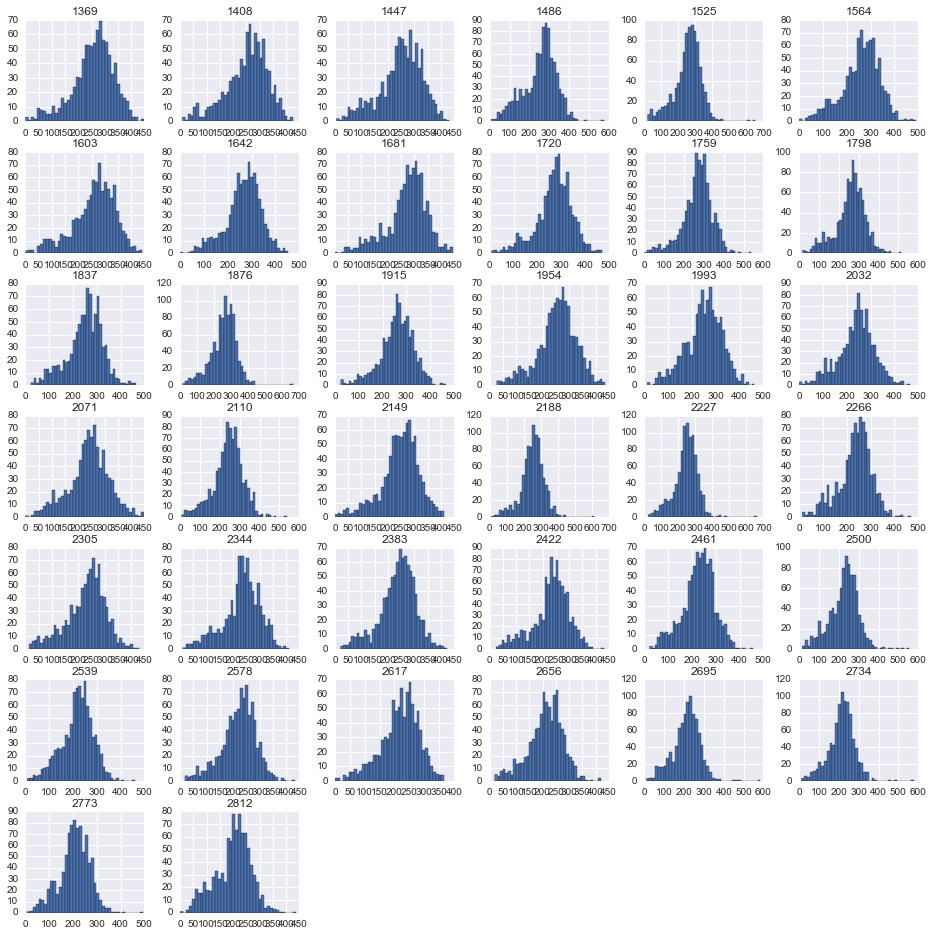

In [3]:
byY = pd.pivot_table(df2, index=['cx','cz'], columns='cy', values='weighted', aggfunc=np.sum)
byY.hist(bins=40, figsize=(16,16));

Divide Y-layers into four groups arbitrarily.

In [4]:
ygroups = np.array([0]*10+[1]*9+[2]*10+[3]*9)

df2['ygroup'] = 0
for y, ygrp in zip(yvals, ygroups):
    df2.loc[df2['cy']==y, 'ygroup'] = ygrp

df2.head()

,cx,cy,cz,unmasked,synapses,weighted,ygroup
6292,448,1369,55,126357,153,238.063772,0
6293,448,1369,166,139932,207,290.840237,0
6294,448,1369,277,150269,194,253.824488,0
6295,448,1369,388,138071,159,226.410122,0
6296,448,1369,499,150842,258,336.278119,0


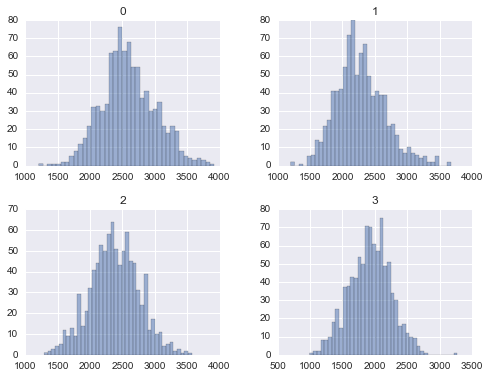

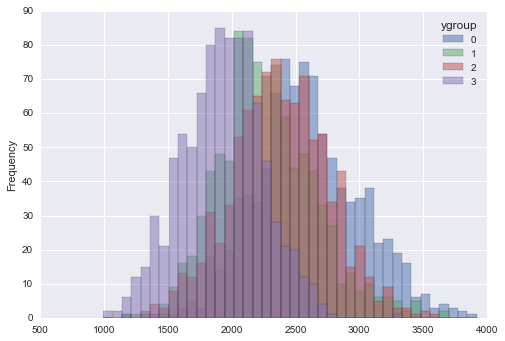

In [5]:
byYgrp = pd.pivot_table(df2, index=['cx','cz'], columns='ygroup', values='weighted', aggfunc=np.sum)

byYgrp.hist(alpha=0.5, bins=40, figsize=(8,6));
plt.show()

byYgrp.plot.hist(alpha=0.5, bins=40);
plt.show()

### 2. Test for Normal Distribution in Y-layer groups

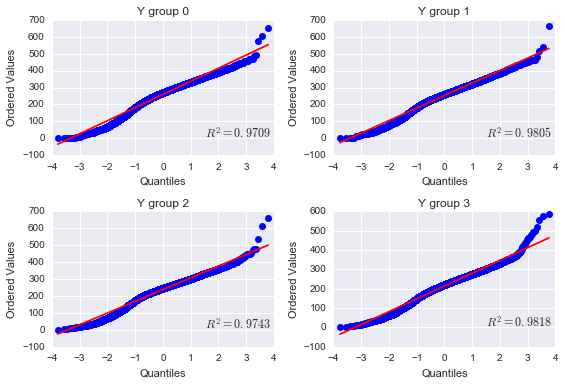

In [6]:
plt.figure()
for i in range(4):
    plt.subplot(221+i)
    ss.probplot(df2[df2['ygroup']==i]['weighted'], plot = plt)
    plt.title('Y group '+str(i))
plt.tight_layout()
plt.show()

The distribution of synapse densities in the Y groups appears close to normal.

### 3. Rank-sum test for difference in Y-layer groups

In [7]:
for i in range(4):
    for j in range(i+1,4):
        stat, p = ss.ranksums(df2[df2['ygroup']==i]['weighted'], df2[df2['ygroup']==j]['weighted'])
        print "Difference between group", i, "and group", j, ": W =", stat, ", p =", p

Difference between group 0 and group 1 : W = 7.78425986509 , p = 7.01224946287e-15
Difference between group 0 and group 2 : W = 22.7987743125 , p = 4.71532470432e-115
Difference between group 0 and group 3 : W = 43.8806094709 , p = 0.0
Difference between group 1 and group 2 : W = 14.6859833474 , p = 7.92757551668e-49
Difference between group 1 and group 3 : W = 37.1732225897 , p = 1.84846735384e-302
Difference between group 2 and group 3 : W = 25.4920297374 , p = 2.41618072244e-143


### 4. Test different numbers of clusters for K-means

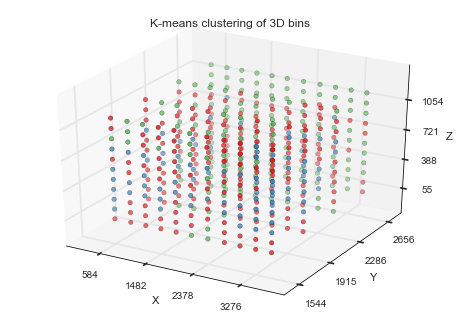

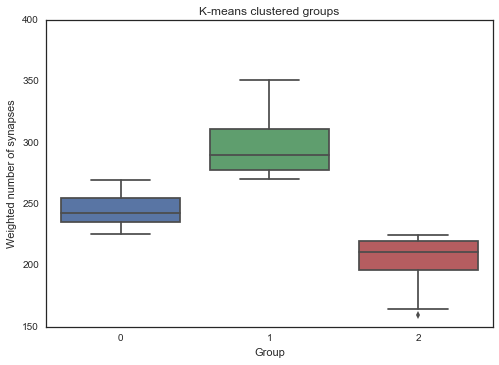

In [8]:
xgroups = np.array([0]*8+[1]*8+[2]*7+[3]*8+[4]*7+[5]*8+[6]*8+[7]*8+[8]*7+[9]*8+[10]*7)
zgroups = np.array(range(0, 11))

df2['xgroup'] = 0
df2['zgroup'] = 0

for x, xgrp in zip(xvals, xgroups):
    df2.loc[df2['cx'] == x, 'xgroup'] = xgrp
for z, zgrp in zip(zvals, zgroups):
    df2.loc[df2['cz'] == z, 'zgroup'] = zgrp
    
df3 = df2.groupby(['xgroup', 'ygroup', 'zgroup']).mean()

from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

data = df3['weighted']

est = KMeans(n_clusters = 3)
est.fit(data.reshape(len(data),1))
labels = est.labels_
df3['label'] = labels
fea = df3[['cx','cy','cz']]

sns.set_style('white')
cmap = np.array(sns.color_palette("Set1", 3))
colors = [cmap[label] for label in labels]
ax = plt.figure().gca(projection='3d')
patches = ax.scatter(xs=fea['cx'], ys=fea['cy'], zs=fea['cz'], 
                     s=20, c=colors,
                     edgecolors=None)
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_zlabel('Z')
plt.title('K-means clustering of 3D bins')
plt.xticks(df3['cx'].unique()[::3])
plt.yticks(df3['cy'].unique())
ax.zaxis.set_ticks(df3['cz'].unique()[::3])
plt.show()

plt.figure()
sns.boxplot(x="label", y="weighted", data=df3)
plt.xlabel('Group')
plt.ylabel('Weighted number of synapses')
plt.title('K-means clustered groups')
plt.show()

### 5. Classification using 3D cubes

In [9]:
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "Random Forest",
         "Linear Discriminant Analysis", "Quadratic Discriminant Analysis"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C = 0.001), 
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

features = fea
y = labels

accuracy=np.zeros((len(classifiers),2))
for idx, cla in enumerate(classifiers):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, y, test_size = 0.4, random_state = 0)
    clf = cla.fit(X_train, y_train)
    loo = LeaveOneOut(len(features))
    scores = cross_validation.cross_val_score(clf, features, y, cv = 2)
    accuracy[idx,] = [scores.mean(), scores.std()]
    print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx], scores.mean(), scores.std() * 2))

Accuracy of Nearest Neighbors: 0.32 (+/- 0.01)
Accuracy of Linear SVM: 0.51 (+/- 0.14)
Accuracy of Random Forest: 0.36 (+/- 0.09)
Accuracy of Linear Discriminant Analysis: 0.46 (+/- 0.09)
Accuracy of Quadratic Discriminant Analysis: 0.38 (+/- 0.09)


## Part 2: Individual Analysis
### San-He

In [10]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from matplotlib import mlab as ML
import pandas as pd
import numpy as np
import itertools
from scipy import stats
from scipy.stats import poisson
from scipy.stats import lognorm
from decimal import *
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import sklearn.mixture
import scipy.stats as ss
import seaborn as sns

# Read in data
df = pd.read_csv('../output.csv')

nvox = 64*64*48
dfcut = df[(df['cx'] > 400) & (df['cx'] < 3800) & (df['cy'] < 2800)]
dfcut['weighted'] = dfcut['synapses'] / dfcut['unmasked'] * nvox
dfftr = dfcut[dfcut['unmasked'] > nvox * 0.5]

/Users/kchang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### 1) Look at data by Z-layer

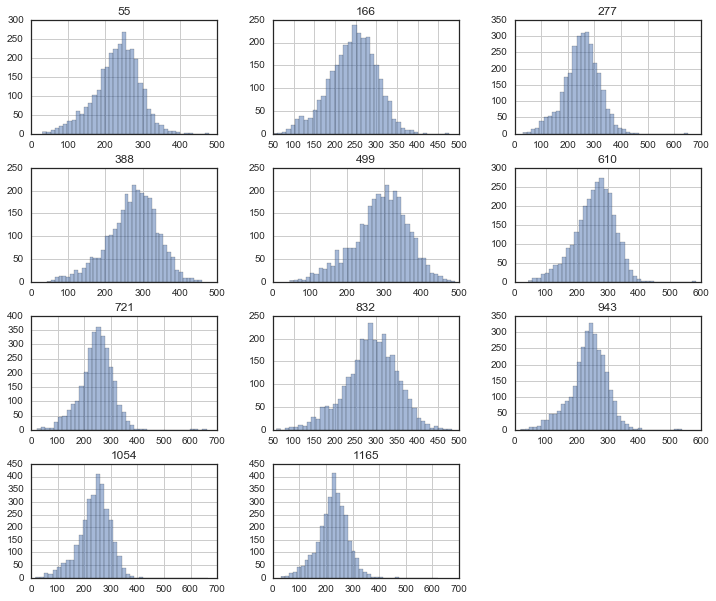

In [11]:
byZgrp = pd.pivot_table(dfftr, index = ['cx','cy'], columns = 'cz', values = 'weighted', aggfunc=np.sum)

byZgrp.hist(alpha = 0.5, bins = 40, figsize = (12, 10))
plt.xlabel('X-coordinate')
plt.ylabel('Z-coordinate')
plt.show()

### 2) Ranksum test of Z-layer

In [12]:
zgroup = dfftr['cz'].unique()

for i in range(11):
    for j in range(i + 1, 11):
        stat, p = ss.ranksums(dfftr[dfftr['cz'] == zgroup[i]]['weighted'], dfftr[dfftr['cz'] == zgroup[j]]['weighted'])
        print "Difference between group", i, "and group", j, ": W =", stat, ", p =", p

Difference between group 0 and group 1 : W = -5.81993531808 , p = 5.88704049455e-09
Difference between group 0 and group 2 : W = -27.5545273759 , p = 3.90575103327e-167
Difference between group 0 and group 3 : W = -10.364444126 , p = 3.59844584033e-25
Difference between group 0 and group 4 : W = -27.4865256107 , p = 2.54409209055e-166
Difference between group 0 and group 5 : W = 2.52318527248 , p = 0.0116297110622
Difference between group 0 and group 6 : W = 2.2927908628 , p = 0.0218600483246
Difference between group 0 and group 7 : W = 12.244615428 , p = 1.7952602601e-34
Difference between group 0 and group 8 : W = 7.13675222147 , p = 9.55618771975e-13
Difference between group 0 and group 9 : W = -2.01229074526 , p = 0.0441892974405
Difference between group 0 and group 10 : W = -18.720949543 , p = 3.3414124437e-78
Difference between group 1 and group 2 : W = -22.1002304227 , p = 3.14458286209e-108
Difference between group 1 and group 3 : W = -4.35649545098 , p = 1.32161438589e-05
Diff

## 3) Descriptive statistics of Y-layer

In [13]:
scy = sorted(dfftr['cy'].unique())

sy1 = dfftr[(dfftr['cy'] >= scy[0]) & (dfftr['cy'] <= scy[9])]
sy2 = dfftr[(dfftr['cy'] >= scy[9]) & (dfftr['cy'] <= scy[19])]
sy3 = dfftr[(dfftr['cy'] >= scy[19]) & (dfftr['cy'] <= scy[29])]
sy4 = dfftr[(dfftr['cy'] >= scy[29]) & (dfftr['cy'] <= scy[36])]

gp = [sy1, sy2, sy3, sy4]

for i in range(1, 5):
    print "Mean and SD of Group", i, "in Y-layer is", np.mean(gp[i-1]['weighted']), "and", sqrt(np.var(gp[i-1]['weighted']))
    

Mean and SD of Group 1 in Y-layer is 271.982529358 and 66.947150189
Mean and SD of Group 2 in Y-layer is 263.788273814 and 65.8839925811
Mean and SD of Group 3 in Y-layer is 245.602294601 and 61.6838190275
Mean and SD of Group 4 in Y-layer is 224.154942892 and 58.7799131039


## 4) Show the density mean synapses density in Y-layer

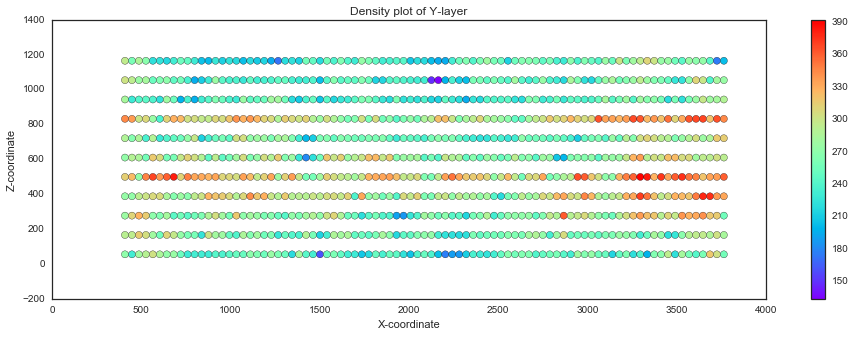

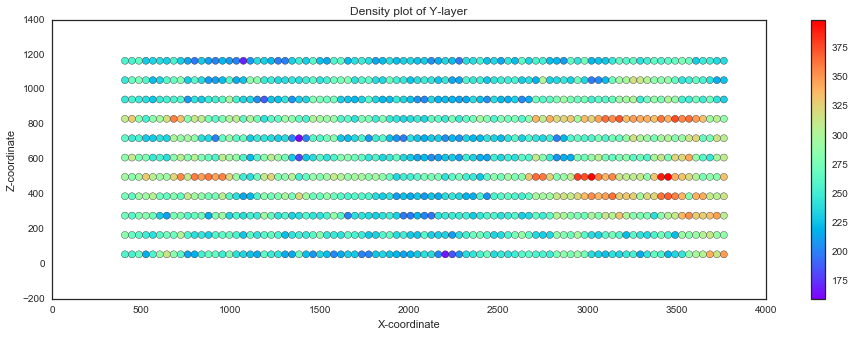

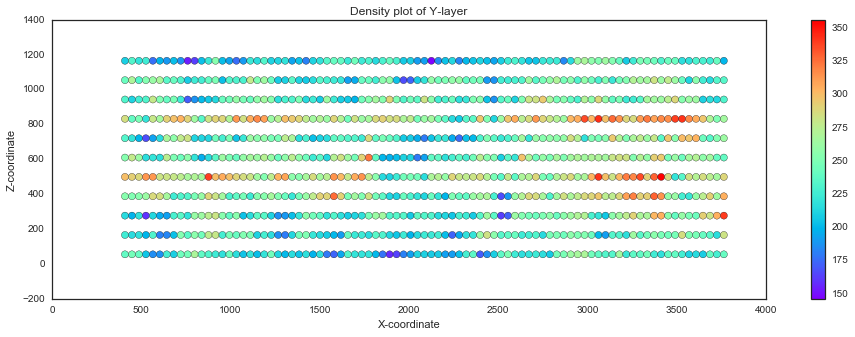

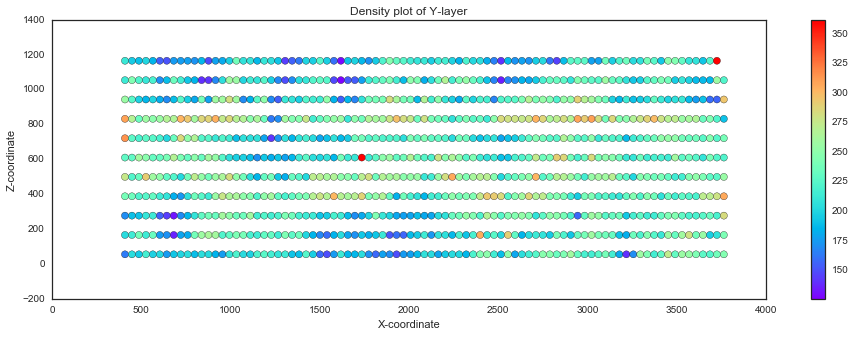

In [14]:
#data.groupby(['col1', 'col2'])['col3'].mean()
#print sy1.groupby(['cx','cz']).sum()
#print sy1
xval = sy1['cx'].unique()
zval = sy1['cz'].unique()
ncx = []
ncz = []
nval = []

for r in [sy1, sy2, sy3, sy4]:
    out = [0, 0, 0]
    for i in xval:
        for j in zval:    
            val = r[(r['cx'] == i) & (r['cz'] == j)]['weighted'].mean()
            out = vstack((out, [i, j, val]))
    df = pd.DataFrame(out)
    df.columns = ['ncx', 'ncz', 'nval']

    m, n = df.shape
    df = df[1:m]
    #print 
    norm = mpl.colors.Normalize(vmin = min(df['nval']), vmax = max(df['nval']))
    cmap = cm.rainbow
    plt.figure(figsize = (16, 5))
    plt.scatter(df['ncx'], df['ncz'], s = 50, cmap = cmap, c = df['nval'], norm = norm)
    plt.xlabel('X-coordinate')
    plt.ylabel('Z-coordinate')
    plt.title('Density plot of Y-layer')
    plt.colorbar()    
    plt.show()


## 5)  Look at the change along X and Y directions 

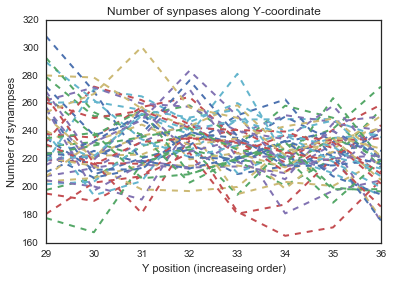

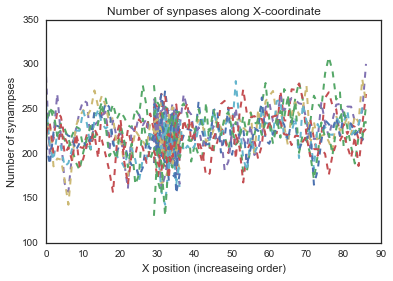

In [15]:
xval = dfftr['cx'].unique()
yval = dfftr['cy'].unique()
zval = dfftr['cz'].unique()
ncx = []
ncz = []
nval = []

output = [0, 0, 0]
for i in xval:
    for j in yval:    
        val = r[(r['cx'] == i) & (r['cy'] == j)]['weighted'].mean()
        output = vstack((output, [i, j, val]))
dfout = pd.DataFrame(output)
dfout.columns = ['ncx', 'ncy', 'nval']
m, n = dfout.shape
dfout = dfout[1:m]

xval = np.hstack((xval[40:87], xval[1:39]))
for i in xval:
    xw = dfout[dfout['ncx'] == i]
    line, = plt.plot(range(0, len(xw['ncx'])), xw['nval'], '--', linewidth = 2)
    if i == 3763:
        plt.xlabel('Y position (increaseing order)')
        plt.ylabel('Number of synampses')
        plt.title('Number of synpases along Y-coordinate')
        plt.show()
        
for i in yval:
    xw = dfout[dfout['ncy'] == i]
    line, = plt.plot(range(0, len(xw['ncy'])), xw['nval'], '--', linewidth = 2)
    if i == 2773:
        plt.xlabel('X position (increaseing order)')
        plt.ylabel('Number of synampses')
        plt.title('Number of synpases along X-coordinate')
        plt.show()



1. Along Y-direction, variation seems very high; along X-direction is smaller a little bit.
2. Looks like they are somewhat periodic along X direction, but hard to find out.
3. Change along X-direction seems more coherent compared to Y-direction.

## Part 3: Kelly

### 0. Setup

In [16]:
np.random.seed(12345678)  # for reproducibility, set random seed

# Read in data
df = pd.read_csv('../output.csv')

nvox = 64*64*48 # assume number of voxels per bin
df['weighted'] = df['synapses']/df['unmasked']*nvox

xvals = df['cx'].unique()
yvals = df['cy'].unique()
zvals = df['cz'].unique()

# Get rid of the blank edges
left = 0;
right = len(xvals);
top = 0;
bottom = len(yvals);
for z in zvals:
    this_z = df[df['cz']==z]
    
    # X direction
    xhist, bin_edges = np.histogram(this_z['cx'], weights = this_z['unmasked']/(nvox*len(yvals)), bins=len(xvals))
    
    left = max(left, np.argmax(xhist>0.5))
    right = min(right, len(xvals)-np.argmax(xhist[::-1]>0.5))
    
    # Y direction
    yhist, bin_edges = np.histogram(this_z['cy'], weights = this_z['unmasked']/(nvox*len(xvals)), bins=len(yvals))
    
    top = max(top, np.argmax(yhist>0.5))
    bottom = min(bottom, len(yvals)-np.argmax(yhist[::-1]>0.5))

# Copy new dataset without edges
df2 = df.copy()
for z in zvals:
    df2.drop(df2.index[(df2['cx']<xvals[left]) | (df2['cx']>=xvals[right])], inplace=True)
    df2.drop(df2.index[(df2['cy']<yvals[top]) | (df2['cy']>=yvals[bottom])], inplace=True)
print "There are", len(df2), "bins after removing the edges."

xvals = df2['cx'].unique()
yvals = df2['cy'].unique()
zvals = df2['cz'].unique()

There are 35112 bins after removing the edges.


### 1. Blur images with Gaussian filter

Gaussian filter with sigma = 0


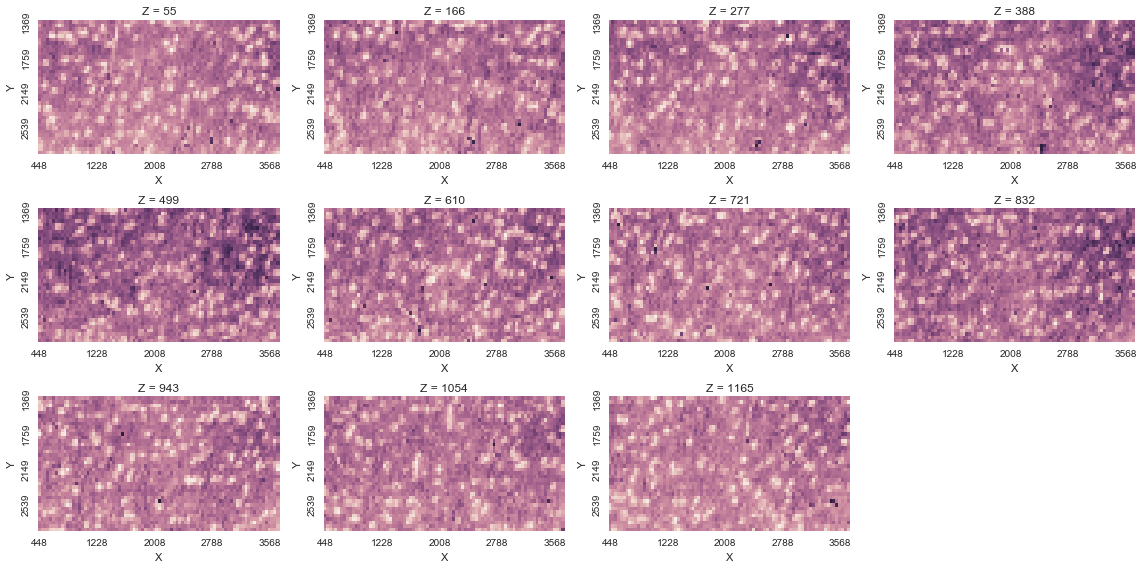

Gaussian filter with sigma = 0.5


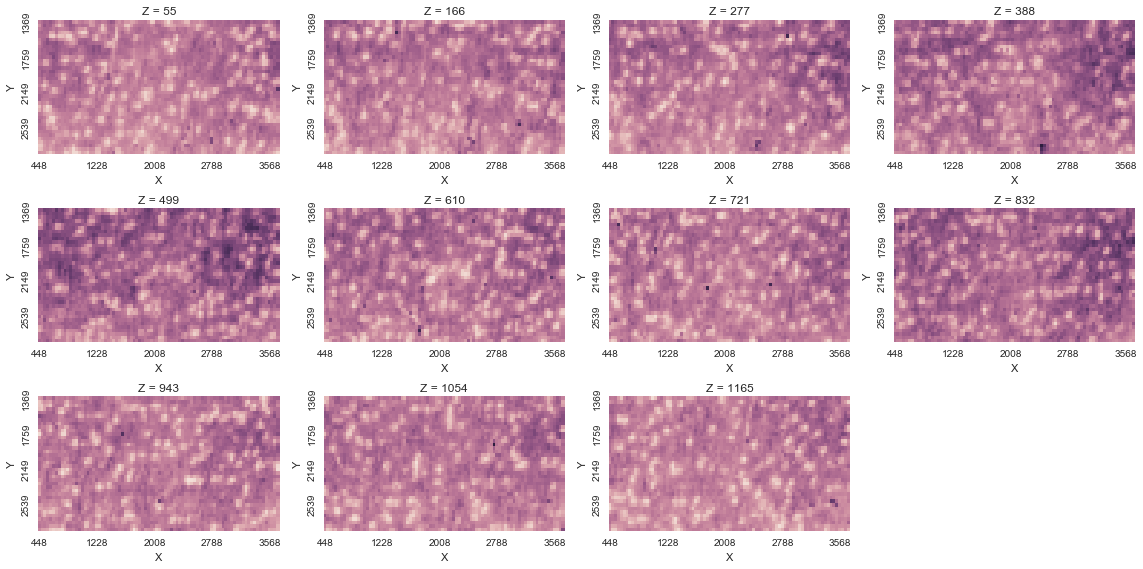

Gaussian filter with sigma = 1


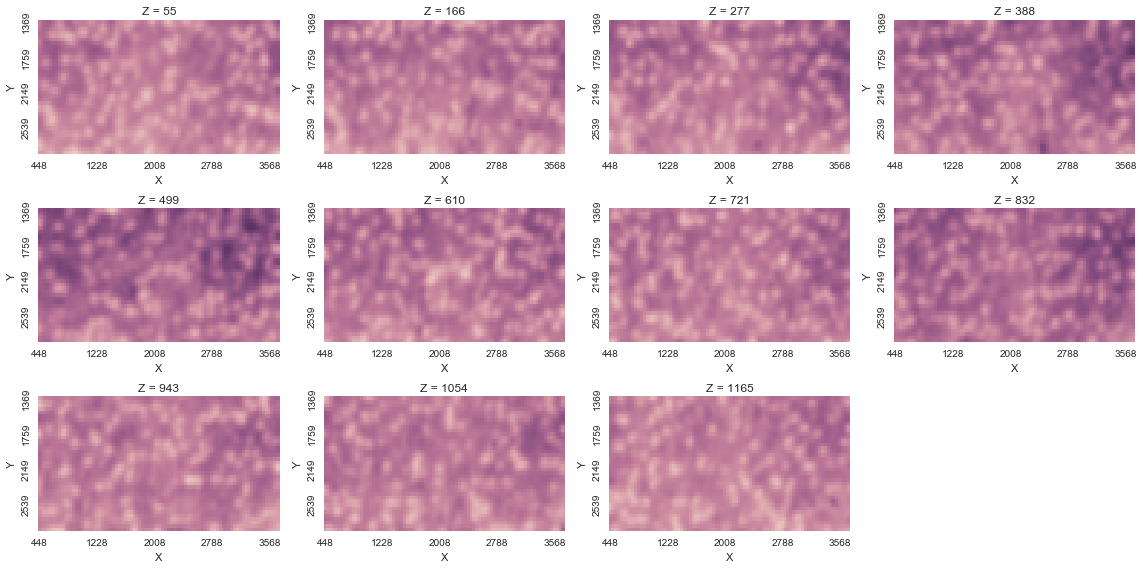

Gaussian filter with sigma = 1.5


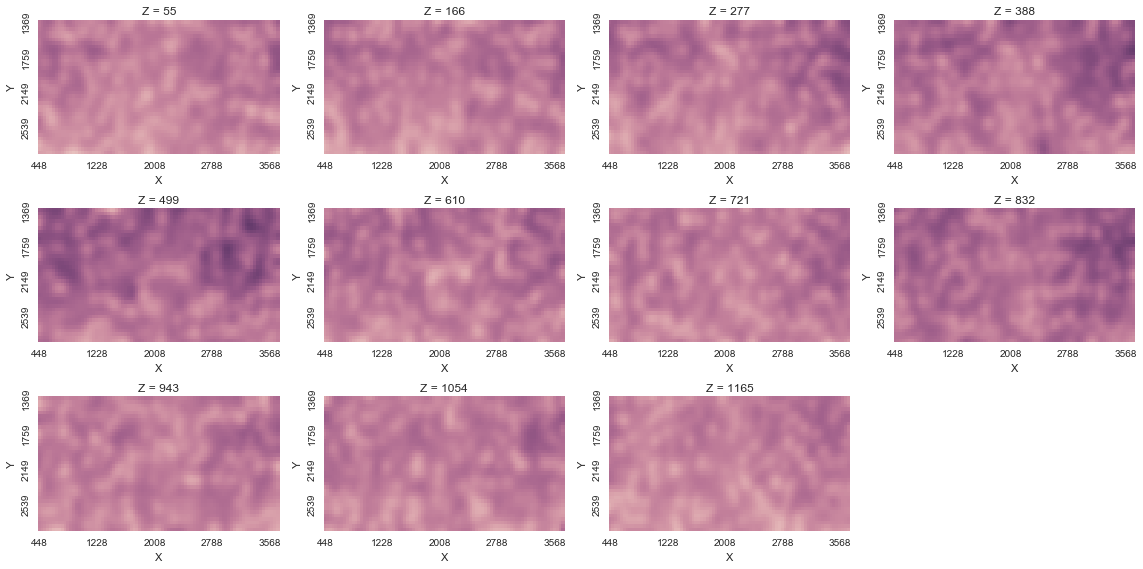

In [17]:
from skimage import filters

S = np.array([
        pd.pivot_table(df2[df2['cx']==x], index='cy', columns='cz', values='weighted', aggfunc=np.sum).values 
        for x in xvals
    ])

sigmas = [0, 0.5, 1, 1.5]

for sigma in sigmas:
    plt.figure(figsize=(16,8))
    print 'Gaussian filter with sigma =', sigma
    for zi, z in enumerate(zvals):
        filtXY = pd.DataFrame(filters.gaussian(S[:,:,zi].T, sigma=sigma), index=yvals, columns=xvals)
        plt.subplot(3,4,1+zi)
        sns.heatmap(filtXY, xticklabels=20, yticklabels=10, vmin=0, vmax=500, cbar=False)
        plt.gca().set_title('Z = '+str(z))
        plt.gca().set_xlabel('X')
        plt.gca().set_ylabel('Y')
        
    plt.tight_layout()
    plt.show()

### 2. Compute GLCM for different patches in Z layers

In [33]:
from skimage.feature import greycomatrix, greycoprops

patch_dim = [14, 12]

df2['patch'] = -1

patch = 0;
for i in range(0,len(xvals)-1,patch_dim[0]):
    for j in range(1,len(yvals)-1,patch_dim[1]):
        left = xvals[i]
        right = xvals[i+patch_dim[0]-1]
        top = yvals[j]
        bottom = yvals[j+patch_dim[1]-1]
        print "patch", patch, ", x bounds: (", left, ",", right, ") , y bounds: (", top, ",", bottom, ")"
        df2.loc[(df2['cx']>=left) & (df['cx']<right) & (df2['cy']>=top) & (df2['cy']<bottom), 'patch'] = patch
        patch = patch+1
print patch, "patches labeled"

npatch = patch

patch 0 , x bounds: ( 448 , 955 ) , y bounds: ( 1408 , 1837 )
patch 1 , x bounds: ( 448 , 955 ) , y bounds: ( 1876 , 2305 )
patch 2 , x bounds: ( 448 , 955 ) , y bounds: ( 2344 , 2773 )
patch 3 , x bounds: ( 994 , 1501 ) , y bounds: ( 1408 , 1837 )
patch 4 , x bounds: ( 994 , 1501 ) , y bounds: ( 1876 , 2305 )
patch 5 , x bounds: ( 994 , 1501 ) , y bounds: ( 2344 , 2773 )
patch 6 , x bounds: ( 1540 , 2047 ) , y bounds: ( 1408 , 1837 )
patch 7 , x bounds: ( 1540 , 2047 ) , y bounds: ( 1876 , 2305 )
patch 8 , x bounds: ( 1540 , 2047 ) , y bounds: ( 2344 , 2773 )
patch 9 , x bounds: ( 2086 , 2593 ) , y bounds: ( 1408 , 1837 )
patch 10 , x bounds: ( 2086 , 2593 ) , y bounds: ( 1876 , 2305 )
patch 11 , x bounds: ( 2086 , 2593 ) , y bounds: ( 2344 , 2773 )
patch 12 , x bounds: ( 2632 , 3139 ) , y bounds: ( 1408 , 1837 )
patch 13 , x bounds: ( 2632 , 3139 ) , y bounds: ( 1876 , 2305 )
patch 14 , x bounds: ( 2632 , 3139 ) , y bounds: ( 2344 , 2773 )
patch 15 , x bounds: ( 3178 , 3685 ) , y bou

Patches for Z = 499


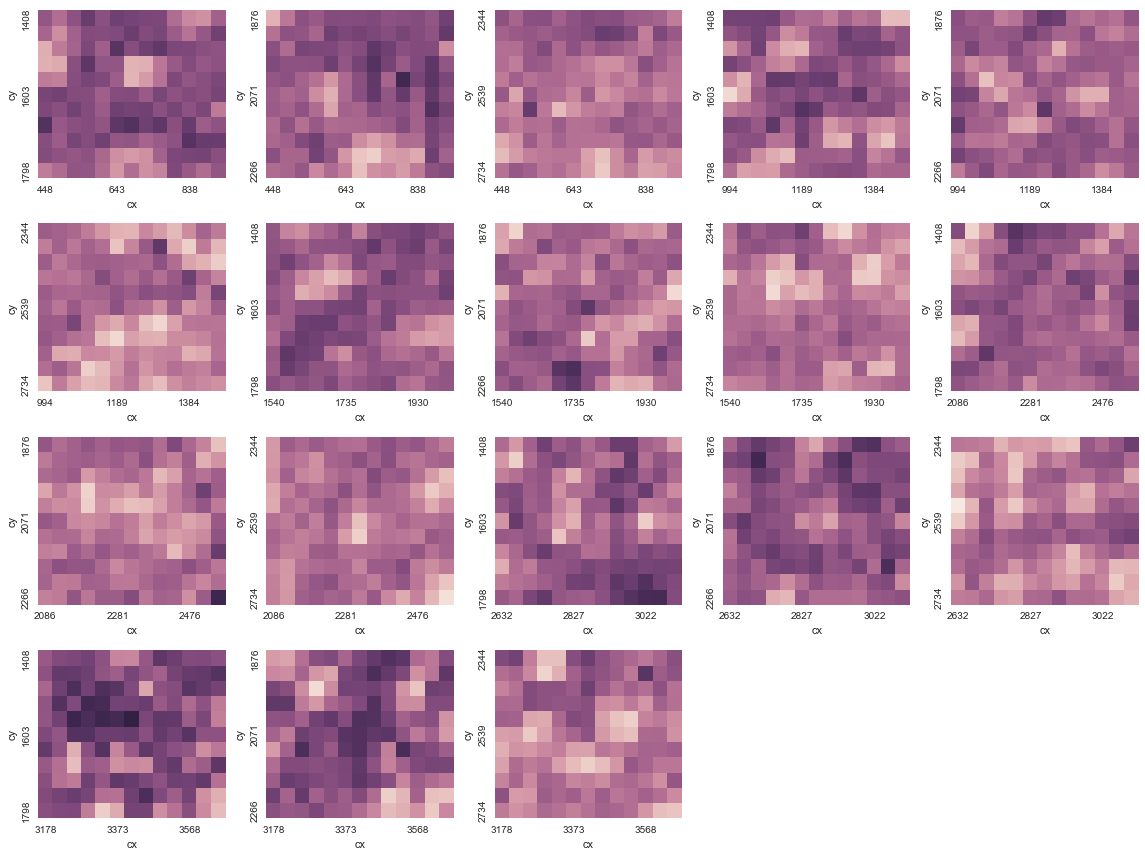

In [19]:
z = zvals[4]
print "Patches for Z =", z

plt.figure(figsize=(16,12))
for patch in range(npatch):
    pdf = pd.pivot_table(df2[(df2['cz']==z) & (df2['patch']==patch)], 
                         index='cy', columns='cx', values='weighted', aggfunc=np.sum)
    plt.subplot(4,5,1+patch)
    sns.heatmap(pdf, xticklabels=5, yticklabels=5, vmin=0, vmax=500, cbar=False)
plt.tight_layout()
plt.show()

GLCM for Z = 499 , number of levels = 5


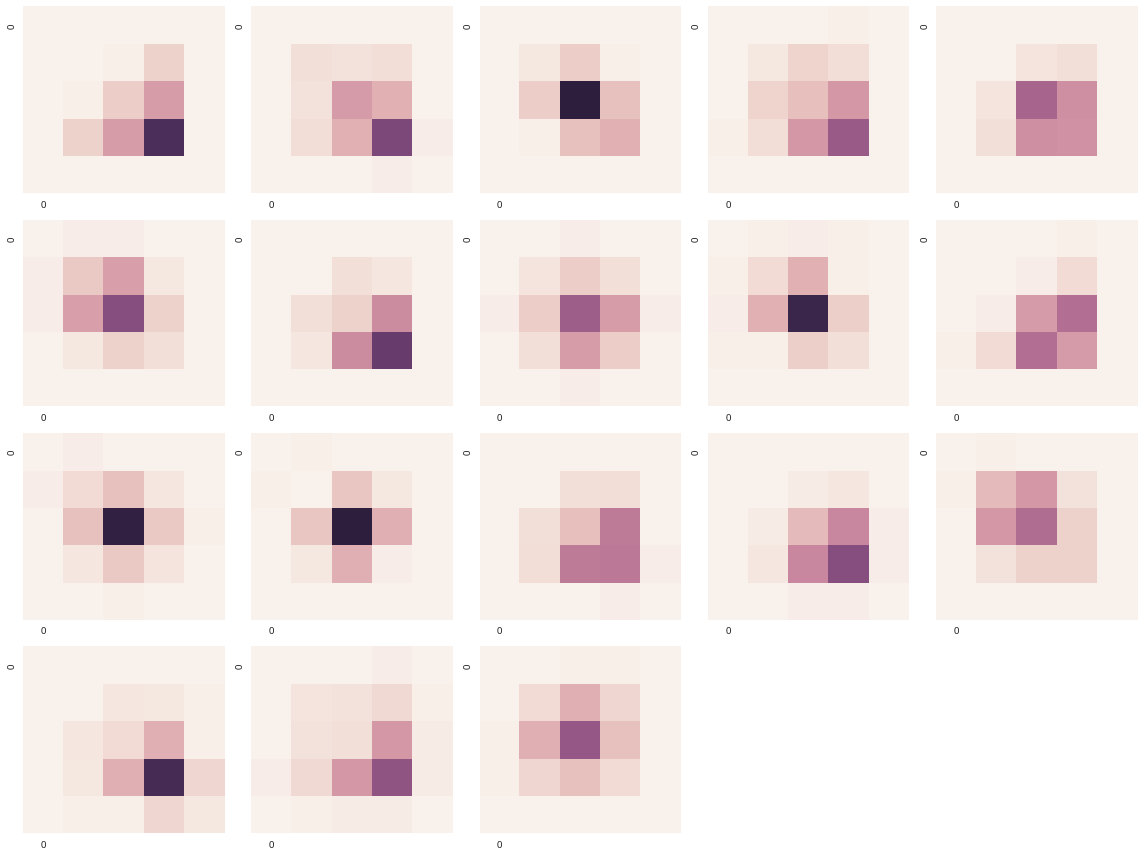

GLCM for Z = 499 , number of levels = 10


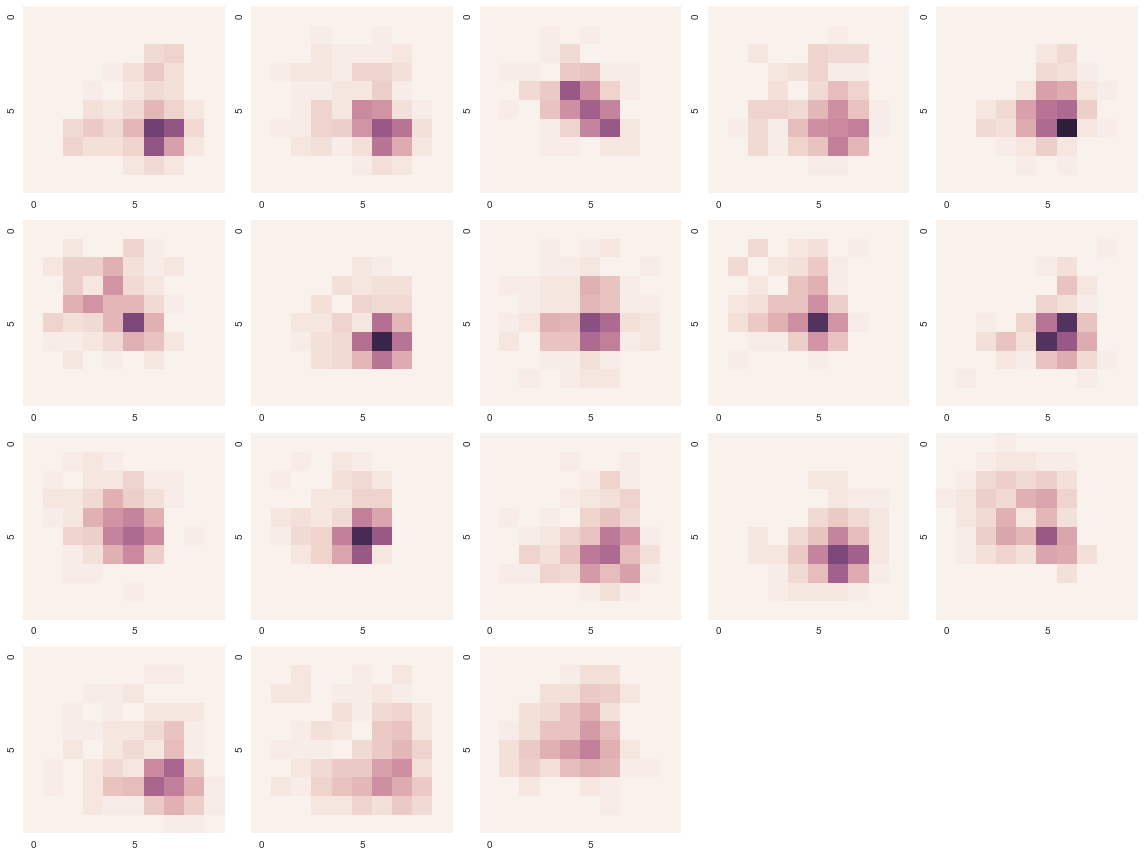

GLCM for Z = 499 , number of levels = 20


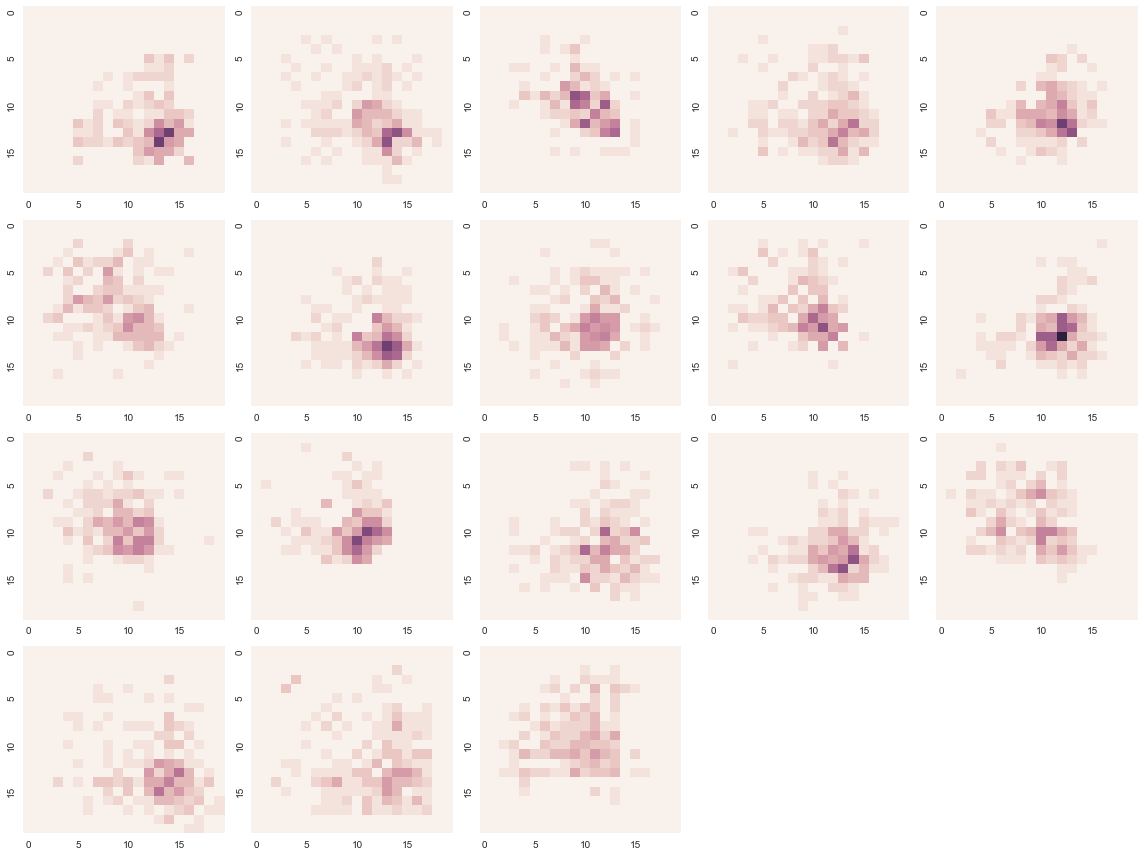

GLCM for Z = 499 , number of levels = 40


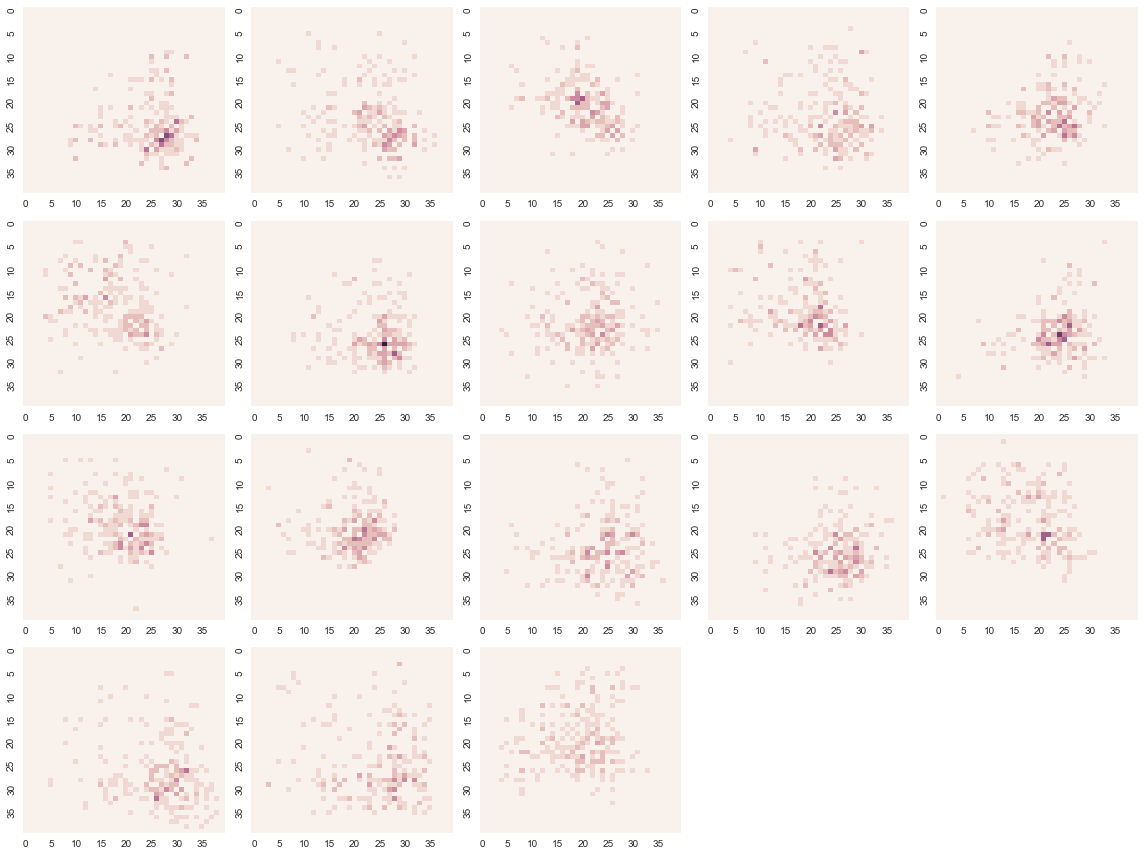

In [20]:
z = zvals[4]
levels_list = [5, 10, 20, 40]

for levels in levels_list:
    print "GLCM for Z =", z, ", number of levels =", levels

    glcm = []
    vmin = float('inf')
    vmax = -float('inf')
    
    plt.figure(figsize=(16,12))
    for patch in range(npatch):
        pdf = pd.pivot_table(df2[(df2['cz']==z) & (df2['patch']==patch)], 
                             index='cy', columns='cx', values='weighted', aggfunc=np.sum)
        pim = np.rint((levels-1)*pdf.values/500).astype(np.uint8)
        pim[pim >= levels] = levels-1
        glcm.append(greycomatrix(pim, [3], [0], levels=levels, symmetric=True, normed=True).reshape(levels,levels))
        vmin = np.min([vmin, np.min(glcm[-1].ravel())])
        vmax = np.max([vmax, np.max(glcm[-1].ravel())])
    
    for patch in range(npatch):
        plt.subplot(4,5,1+patch)
        sns.heatmap(glcm[patch], xticklabels=5, yticklabels=5, vmin=vmin, vmax=vmax, cbar=False)
    plt.tight_layout()
    plt.show()

### 3. Vary GLCM distance and angle parameters

Patch = 0


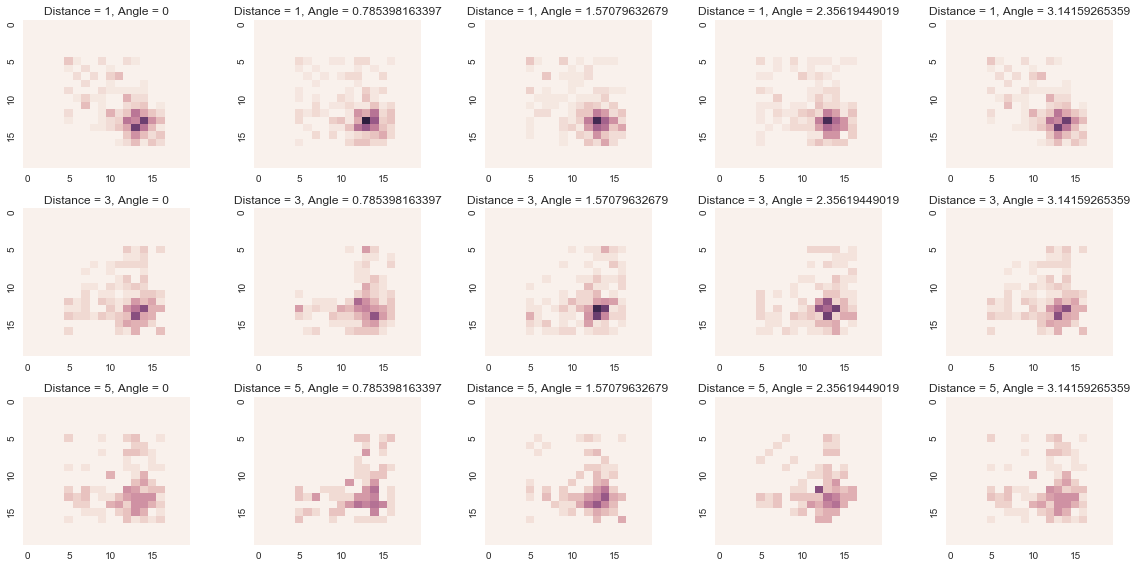

Patch = 6


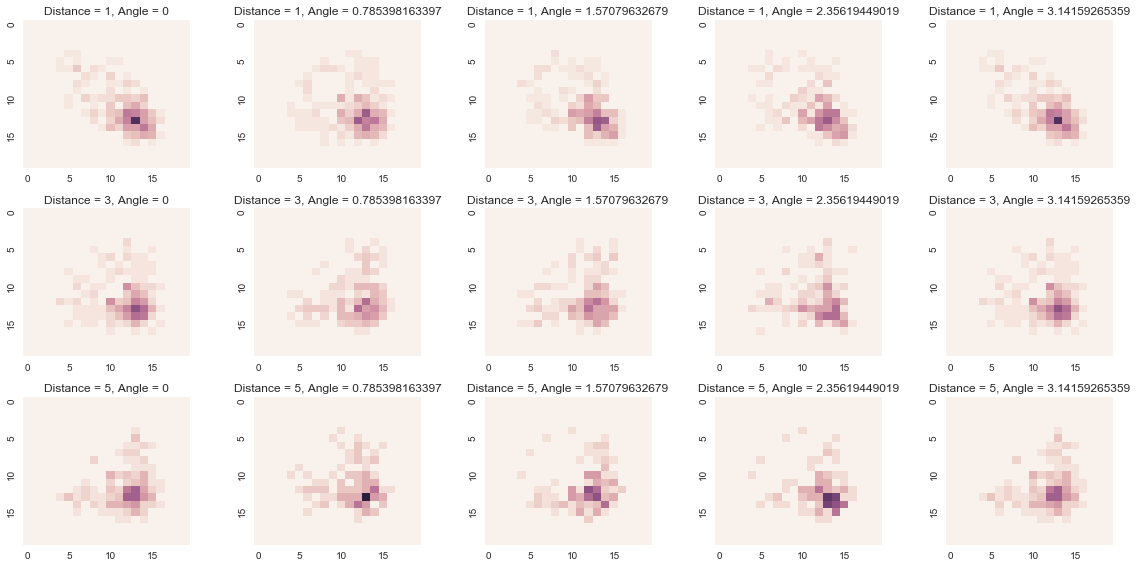

Patch = 12


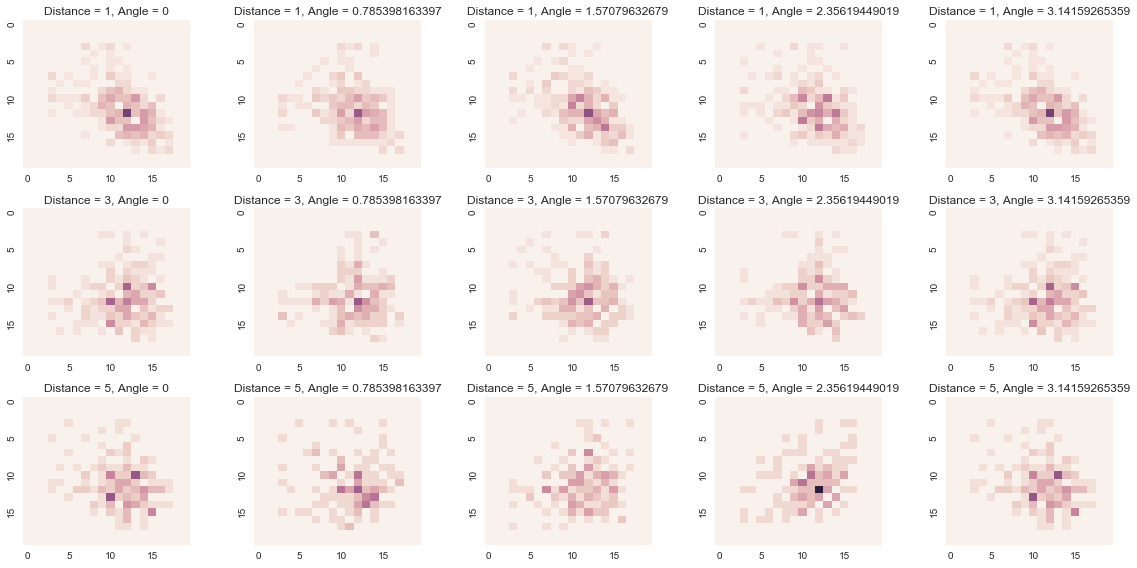

In [21]:
z = zvals[4]
levels = 20
dist_list = [1, 3, 5]
ang_list = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]

for patch in range(0,npatch,6):
    
    print "Patch =", patch

    glcm = []
    vmin = float('inf')
    vmax = -float('inf')

    pdf = pd.pivot_table(df2[(df2['cz']==z) & (df2['patch']==patch)], 
                         index='cy', columns='cx', values='weighted', aggfunc=np.sum)
    pim = np.rint((levels-1)*pdf.values/500).astype(np.uint8)
    pim[pim >= levels] = levels-1
    glcm = greycomatrix(pim, dist_list, ang_list, levels=levels, symmetric=True, normed=True)
#     vmin = np.min([vmin, np.min(glcm[-1].ravel())])
#     vmax = np.max([vmax, np.max(glcm[-1].ravel())])

    plt.figure(figsize=(16,8))
    fidx = 0
    for i, dist in enumerate(dist_list):
        for j, ang in enumerate(ang_list):
            plt.subplot(len(dist_list),len(ang_list),1+fidx)
            sns.heatmap(glcm[:,:,i,j].reshape(levels,levels), 
                        xticklabels=5, yticklabels=5, vmin=0, vmax=np.max(glcm.ravel()), cbar=False)
            plt.title("Distance = "+str(dist)+", Angle = "+str(ang))
            fidx = fidx+1
    plt.tight_layout()
    plt.show()

### 4. Compute GLCM properties

In [30]:
z = zvals[4]
levels = 20
dist = 3
ang = np.pi/2

props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
nprops = len(props)

df_list = []
for j, z in enumerate(zvals):
    patchprops = np.zeros((npatch, nprops))
    xdata = []
    ydata = []
    
    for patch in range(npatch):
        pdf = pd.pivot_table(df2[(df2['cz']==z) & (df2['patch']==patch)], 
                             index='cy', columns='cx', values='weighted', aggfunc=np.sum)
        pim = np.rint((levels-1)*pdf.values/500).astype(np.uint8)
        pim[pim >= levels] = levels-1
        glcm = greycomatrix(pim, [dist], [ang], levels=levels, symmetric=True, normed=True)
        xdata.append(np.mean(pdf.columns.values))
        ydata.append(np.mean(pdf.index.values))
        
        for i, prop in enumerate(props):
#             print greycoprops(glcm, prop)[0, 0]
            patchprops[patch,i] = greycoprops(glcm, prop)[0, 0]
            
    tempdf = pd.DataFrame(patchprops, index=range(npatch), columns=props)
    tempdf['patch'] = tempdf.index
    tempdf['cx'] = xdata
    tempdf['cy'] = ydata
    tempdf['cz'] = z
    df_list.append(tempdf)
ppdf = pd.concat(df_list)

ppdf.head()

,contrast,dissimilarity,homogeneity,energy,correlation,patch,cx,cy,cz
0,21.317308,3.509615,0.275424,0.133061,-0.062332,0,682.0,1603.0,55
1,13.528846,2.778846,0.319817,0.173477,-0.234841,1,682.0,2071.0,55
2,8.000000,2.076923,0.421682,0.188300,0.087700,2,682.0,2539.0,55
3,18.221154,3.355769,0.256516,0.132015,-0.110989,3,1228.0,1603.0,55
4,11.528846,2.721154,0.292343,0.137839,0.204580,4,1228.0,2071.0,55


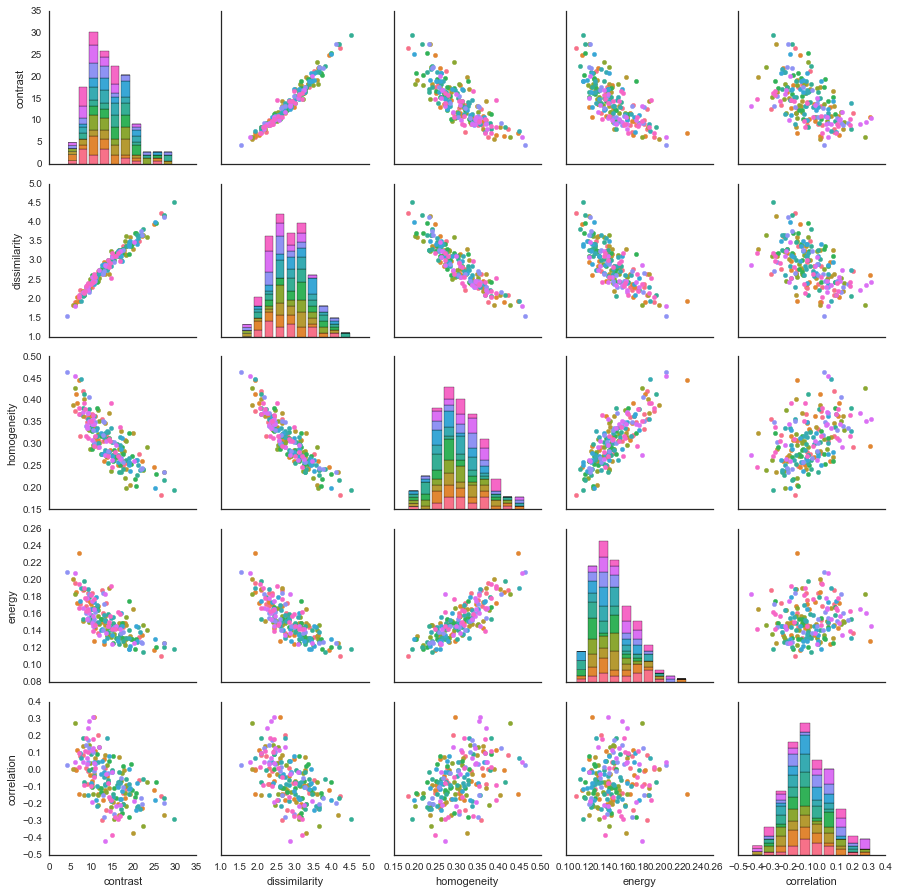

In [34]:
g = sns.PairGrid(ppdf, hue='cz', vars=props)
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

### 5. Entropy of Z layers

Entropy with disk = 5


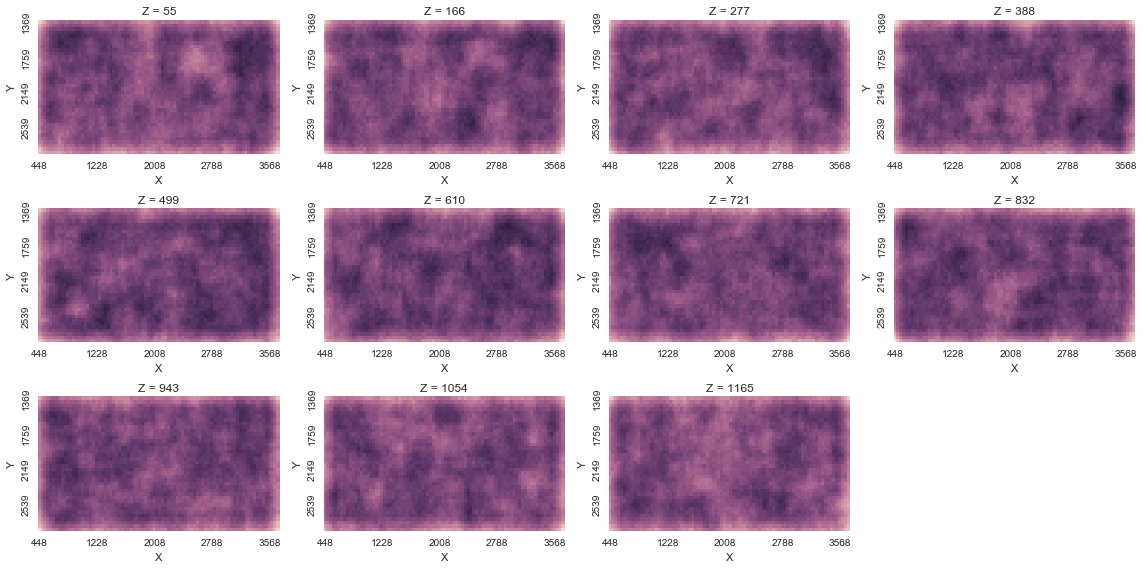

Entropy with disk = 10


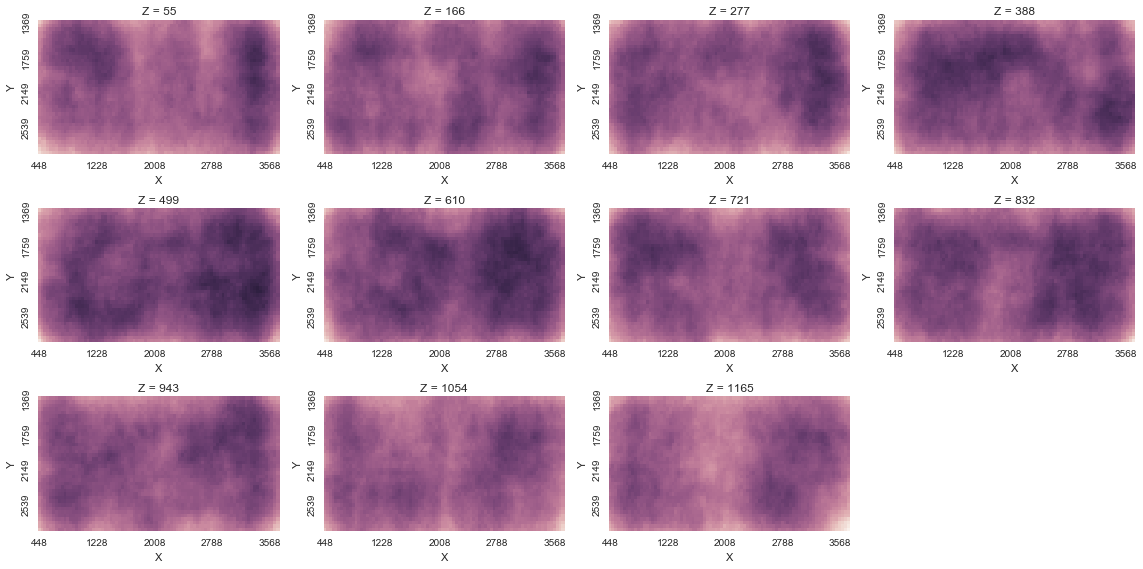

Entropy with disk = 15


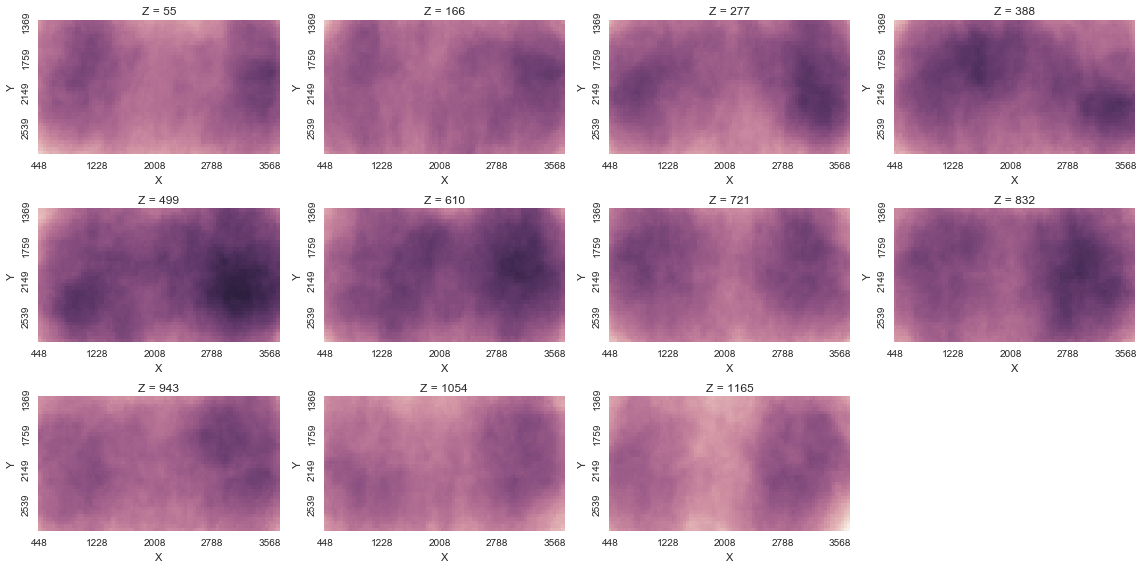

Entropy with disk = 20


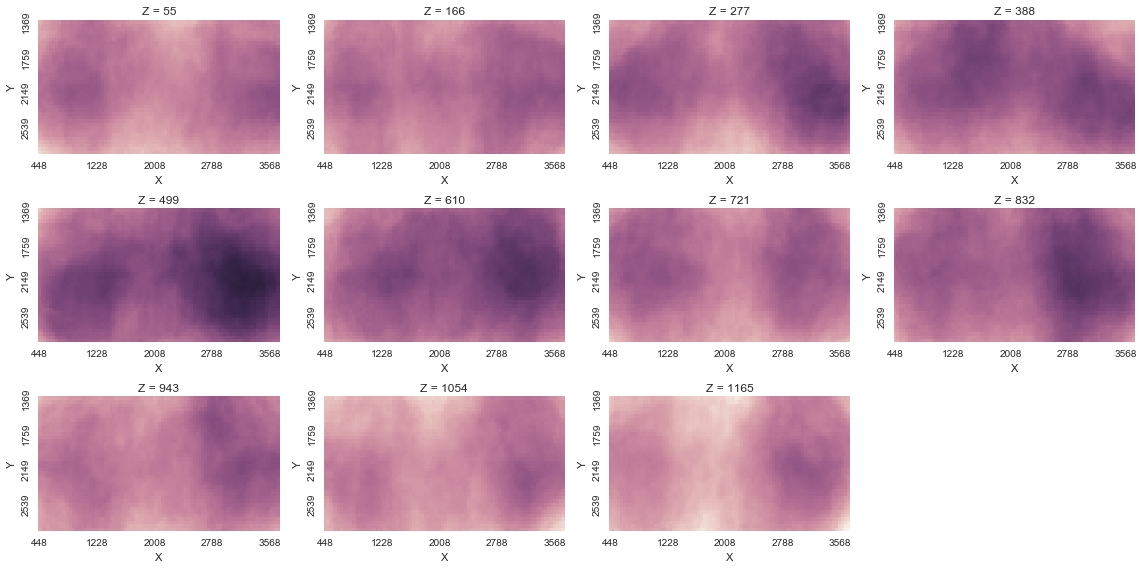

In [24]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

diams = [5, 10, 15, 20]

for d in diams:
    plt.figure(figsize=(16,8))
    print 'Entropy with disk =', d
    entXY = []
    vmin = float('inf')
    vmax = -float('inf')
    for zi, z in enumerate(zvals):
        imXY = np.rint(255*(S[:,:,zi].T/500)).astype(np.uint8)
        imXY[imXY > 255] = 255
        
        entXY.append(pd.DataFrame(entropy(imXY, disk(d)), index=yvals, columns=xvals))
        vmin = np.min([vmin, np.min(entXY[-1].values.ravel())])
        vmax = np.max([vmax, np.max(entXY[-1].values.ravel())])
    
    for zi, z in enumerate(zvals):
        plt.subplot(3,4,1+zi)
        sns.heatmap(entXY[zi], xticklabels=20, yticklabels=10, vmin=vmin, vmax=vmax, cbar=False)
        plt.gca().set_title('Z = '+str(z))
        plt.gca().set_xlabel('X')
        plt.gca().set_ylabel('Y')
    plt.tight_layout()
    plt.show()